# 剪枝时机

## 训练后剪枝


In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.nn.functional as F
from torchvision import datasets

from torchprofile import profile_macs


# 设置 matplotlib 使用支持负号的字体
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [4]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = LeNet()


In [5]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
train_dataset = datasets.MNIST(root='0.minist_classify/data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='0.minist_classify/data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    inputs = inputs
    targets = targets

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer 
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [8]:
# 加载之前模型训练后的状态字典
checkpoint = torch.load('0.minist_classify/model.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)

# 备份model
origin_model = copy.deepcopy(model)

/tmp/ipykernel_3781/1522452300.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('0.minist_classify/model.pt')


In [9]:
origin_model_accuracy = evaluate(origin_model, test_loader)
origin_model_size = get_model_size(origin_model)
print(f"dense model has accuracy={origin_model_accuracy:.2f}%")
print(f"dense model has size={origin_model_size/MiB:.2f}%MiB")

eval:   0%|          | 0/157 [00:00<?, ?it/s]

dense model has accuracy=97.99%
dense model has size=0.17%MiB


In [10]:
# 绘制权重分布图
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))

    # 删除多余的子图（我们只需要5个子图）
    fig.delaxes(axes[1][2])
    
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

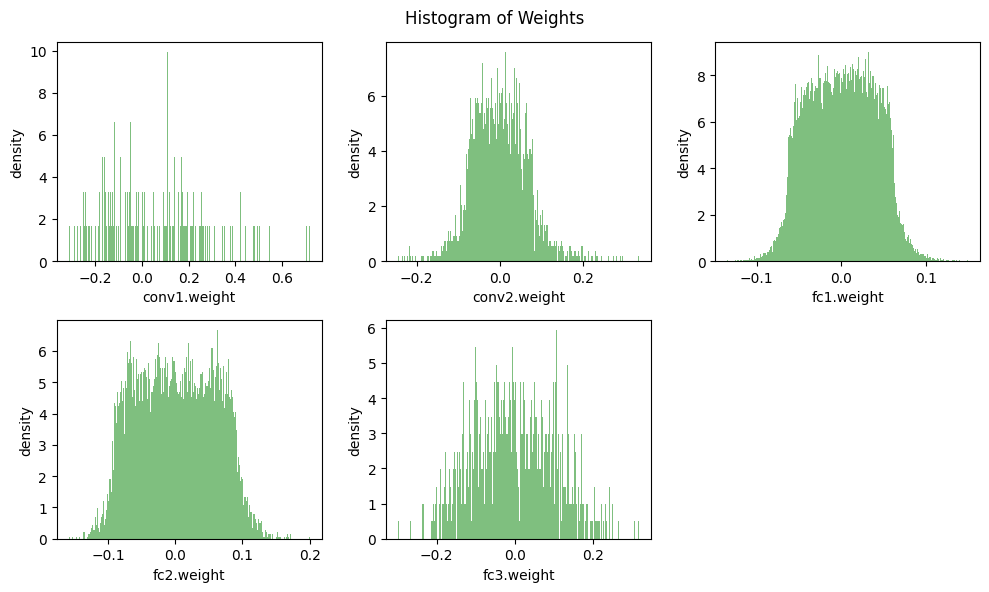

In [11]:
# 绘制weight直方图
plot_weight_distribution(model)

In [12]:

# 计算每一层网络的稠密程度
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    num_nonzeros, num_elements = 0, 0
    for name,param in model.named_parameters():
        if param.dim() > 1:
            num_nonzeros = param.count_nonzero()
            num_elements = param.numel()
            dense = float(num_nonzeros) / num_elements
            num_parameters[name] = dense
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    
    bars = plt.bar(list(num_parameters.keys()), list(num_parameters.values()))

    # 在柱状图上添加数据标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, yval, va='bottom')  # va='bottom' 使得文本在柱状图上方

    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

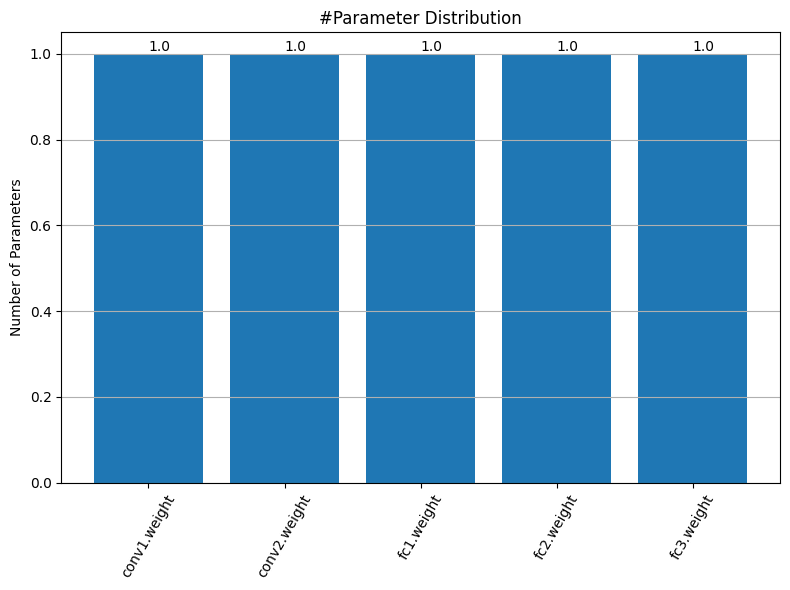

In [13]:
# 列出weight分布图
plot_num_parameters_distribution(model)

## 模型剪枝

In [14]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()
    num_zeros = round(num_elements * sparsity)
    importance = tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values
    mask = torch.gt(importance, threshold)
    tensor.mul_(mask)

    return mask

In [15]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [16]:
sparsity_dict = {
    'conv1.weight': 0.85,
    'conv2.weight': 0.8,
    'fc1.weight': 0.75,
    'fc2.weight': 0.7,
    'fc3.weight': 0.8,
}

After pruning with sparsity dictionary
  conv1.weight: 0.85
  conv2.weight: 0.80
  fc1.weight: 0.75
  fc2.weight: 0.70
  fc3.weight: 0.80
The sparsity of each layer becomes
  conv1.weight: 0.85
  conv2.weight: 0.80
  fc1.weight: 0.75
  fc2.weight: 0.70
  fc3.weight: 0.80
Sparse model has size=0.04 MiB = 26.13% of orgin model size


eval:   0%|          | 0/157 [00:00<?, ?it/s]

Sparse model has accuracy=66.46% before fintuning


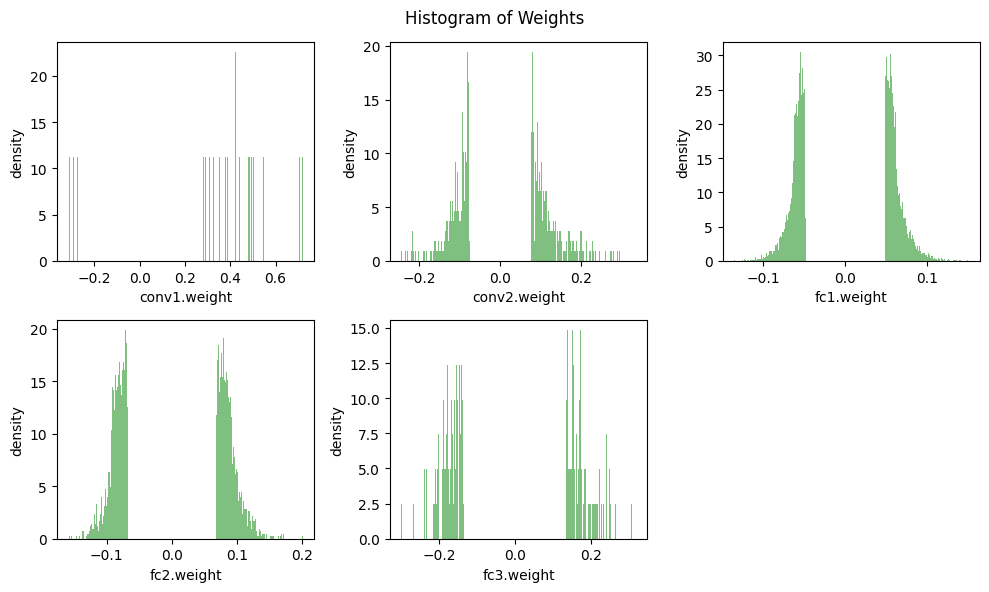

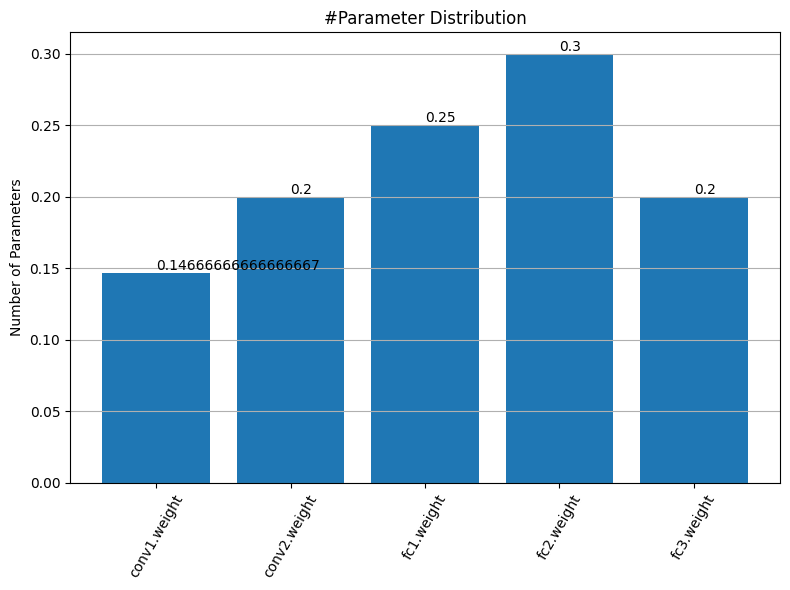

In [17]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / origin_model_size * 100:.2f}% of orgin model size")
sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)


plot_num_parameters_distribution(model)

## 微调模型

In [18]:
lr = 0.01
momentum = 0.5
num_finetune_epochs = 5

optimizer = torch.optim.SGD(model.parameters(),  lr=lr, momentum=momentum)  # lr学习率，momentum冲量
criterion = nn.CrossEntropyLoss()  # 交叉熵损失


best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, train_loader, criterion, optimizer,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, test_loader)
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

    Epoch 1 Accuracy 97.47% / Best Accuracy: 97.47%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

    Epoch 2 Accuracy 97.49% / Best Accuracy: 97.49%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

    Epoch 3 Accuracy 97.79% / Best Accuracy: 97.79%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

    Epoch 4 Accuracy 97.78% / Best Accuracy: 97.79%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

    Epoch 5 Accuracy 98.01% / Best Accuracy: 98.01%


In [19]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / origin_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=0.04 MiB = 26.13% of dense model size


eval:   0%|          | 0/157 [00:00<?, ?it/s]

Sparse model has accuracy=98.01% after fintuning


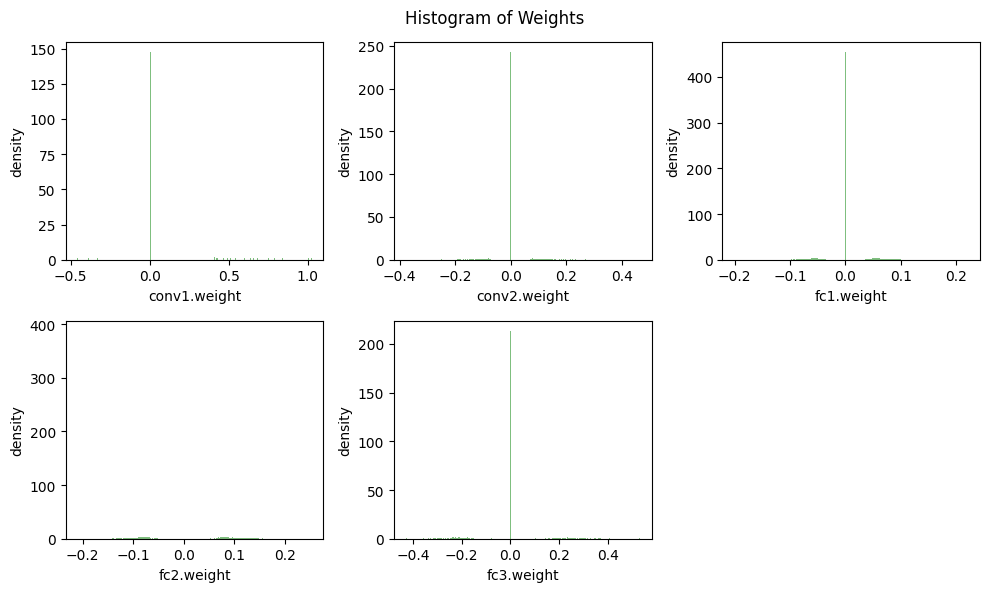

In [20]:
# 绘制weight直方图
plot_weight_distribution(model)

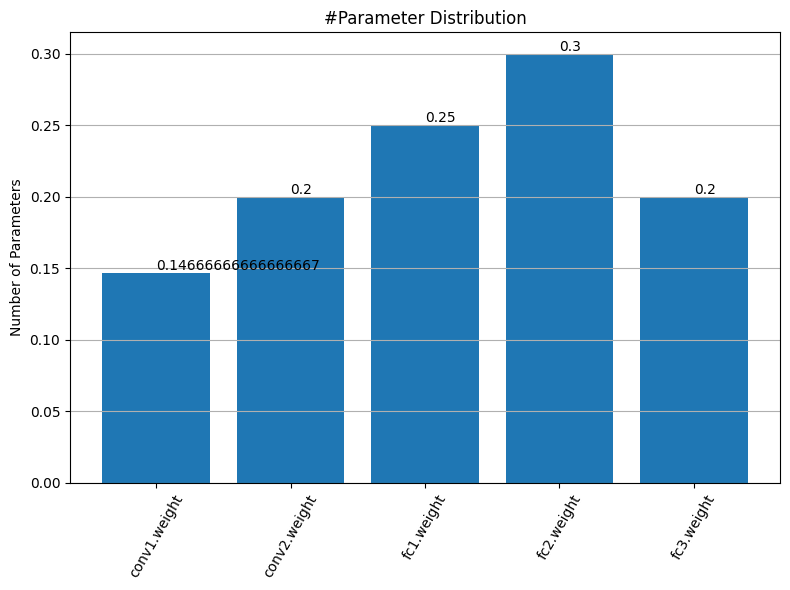

In [21]:
# 列出weight分布图
plot_num_parameters_distribution(model)

Origin model has size=0.17 MiB


eval:   0%|          | 0/157 [00:00<?, ?it/s]

Origin model has accuracy=97.99% 


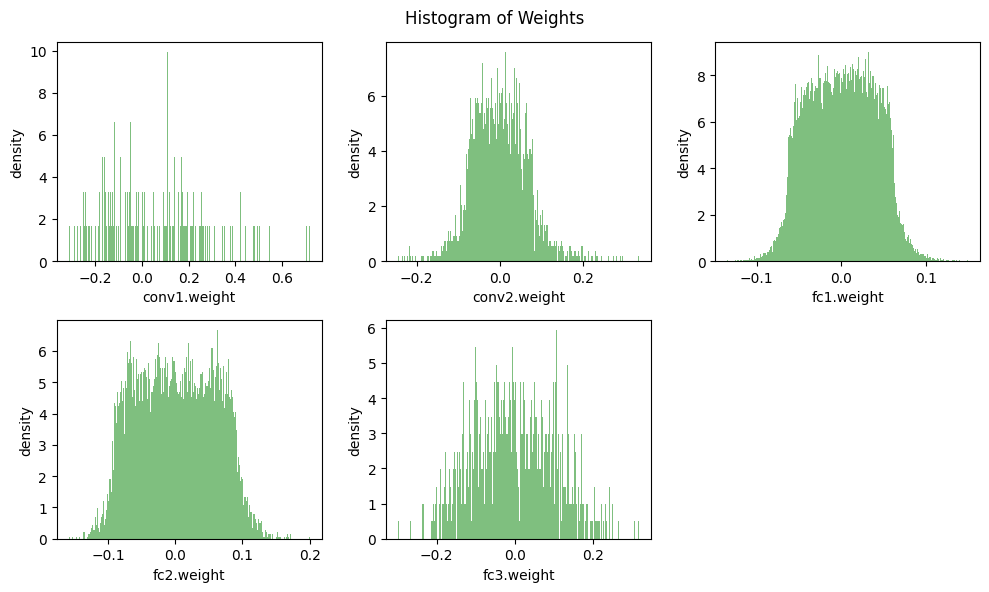

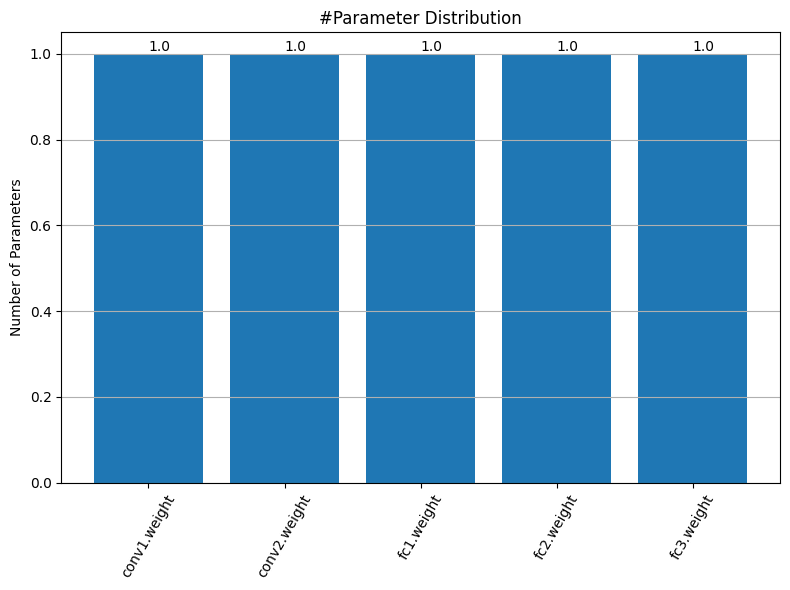

In [22]:

origin_model_size = get_model_size(origin_model, count_nonzero_only=True)
print(f"Origin model has size={origin_model_size / MiB:.2f} MiB")
origin_model_accuracy = evaluate(origin_model, test_loader)
print(f"Origin model has accuracy={origin_model_accuracy:.2f}% ")

plot_weight_distribution(origin_model, count_nonzero_only=True)


plot_num_parameters_distribution(origin_model)

In [23]:
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

dummy_input = torch.randn(64, 1, 28, 28)


pruned_latency = measure_latency(model, dummy_input)
original_latency = measure_latency(origin_model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(origin_model, dummy_input)
pruned_macs = get_model_macs(model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(origin_model, count_nonzero_only=True).item()
pruned_param = get_num_parameters(model, count_nonzero_only=True).item()
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

                Original        Pruned          Reduction Ratio
Latency (ms)    1.1             1.1             1.0            
MACs (M)        18              18              1.0            
Param (M)       0.04            0.01            3.8            
